In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [10]:
df = pd.read_csv("heart.csv")    # adjust filename/path
df.head()
df.info()
df.isna().sum()
df['target'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


target
1    526
0    499
Name: count, dtype: int64

In [11]:
df['target'] = (df['target'] > 0).astype(int)


In [12]:
# simple fix example: replace zeros in chol or trestbps if they are clearly invalid
for col in ['chol','trestbps']:
    df[col] = df[col].replace(0, np.nan)
    df[col].fillna(df[col].median(), inplace=True)

# one-hot some categorical columns
cat_cols = ['cp','thal','slope','restecg']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# features / target
X = df.drop('target', axis=1)
y = df['target']


C:\Users\harsh\AppData\Local\Temp\ipykernel_16336\2432704668.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


Train acc: 1.0
Test  acc: 0.9883268482490273


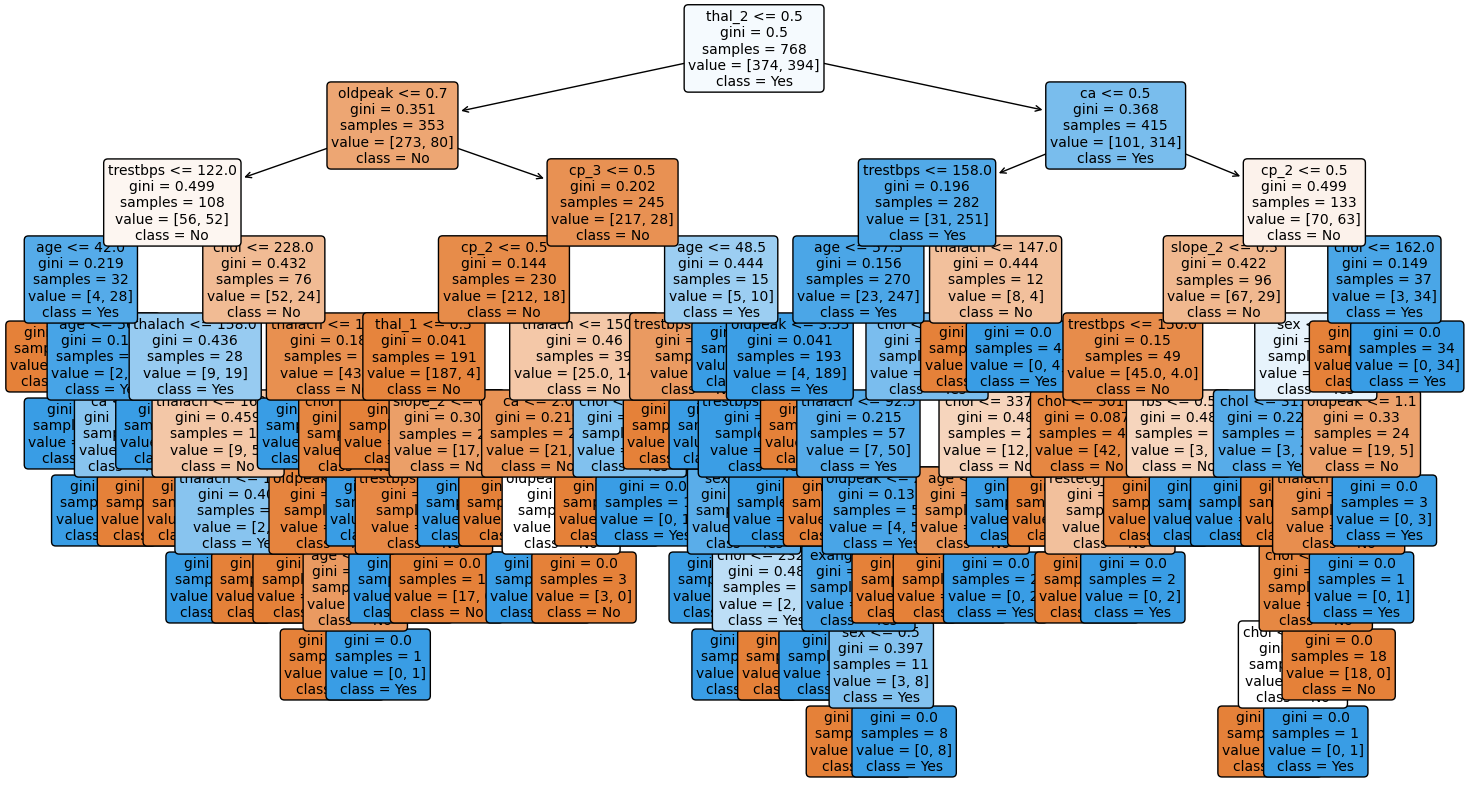

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# simple performance
print("Train acc:", dt.score(X_train, y_train))
print("Test  acc:", dt.score(X_test, y_test))

# visualize (matplotlib)
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names=X.columns, class_names=['No','Yes'], filled=True, rounded=True, fontsize=10)
plt.show()


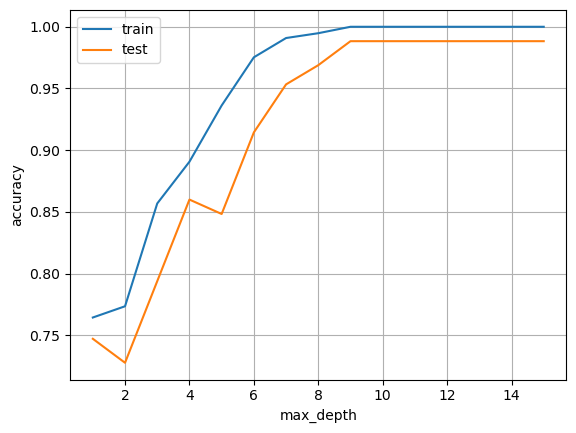

1 0.764 0.747
2 0.773 0.728
3 0.857 0.794
4 0.891 0.86
5 0.936 0.848
6 0.975 0.914
7 0.991 0.953
8 0.995 0.969
9 1.0 0.988
10 1.0 0.988
11 1.0 0.988
12 1.0 0.988
13 1.0 0.988
14 1.0 0.988
15 1.0 0.988


In [15]:
depths = list(range(1,16))
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.plot(depths, train_scores, label='train')
plt.plot(depths, test_scores, label='test')
plt.xlabel('max_depth'); plt.ylabel('accuracy'); plt.legend(); plt.grid(True)
plt.show()

for d, tr, te in zip(depths, train_scores, test_scores):
    print(d, round(tr,3), round(te,3))


In [16]:
best_depth = 4   # example — pick from above sweep
dt_tuned = DecisionTreeClassifier(max_depth=best_depth, random_state=42, min_samples_leaf=5)
dt_tuned.fit(X_train, y_train)

y_pred = dt_tuned.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8482490272373541
              precision    recall  f1-score   support

           0       0.88      0.79      0.84       125
           1       0.82      0.90      0.86       132

    accuracy                           0.85       257
   macro avg       0.85      0.85      0.85       257
weighted avg       0.85      0.85      0.85       257

Confusion matrix:
 [[ 99  26]
 [ 13 119]]


In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("RF accuracy:", accuracy_score(y_test, y_pred_rf))
print("DT (tuned) accuracy:", accuracy_score(y_test, y_pred))


RF accuracy: 1.0
DT (tuned) accuracy: 0.8482490272373541


thalach      0.116413
ca           0.112223
oldpeak      0.107318
thal_2       0.098326
age          0.089629
thal_3       0.078027
chol         0.075951
trestbps     0.074883
exang        0.058944
cp_2         0.043131
slope_2      0.030165
sex          0.029510
restecg_1    0.021167
slope_1      0.018484
cp_3         0.017424
dtype: float64


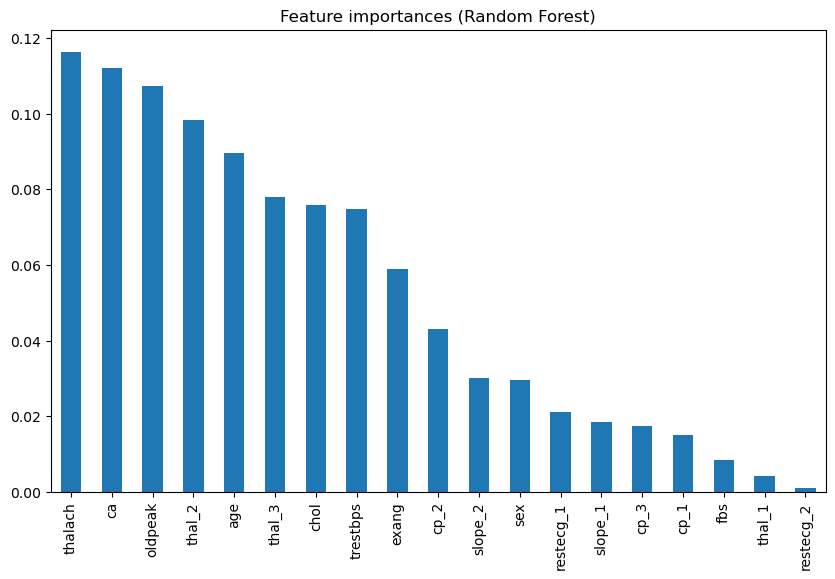

In [18]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(15))

# bar plot
plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Feature importances (Random Forest)")
plt.show()


In [19]:
scoring = ['accuracy','precision','recall','roc_auc']
scores = cross_validate(RandomForestClassifier(n_estimators=200, random_state=42), X, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
for key in scoring:
    print(key, "mean:", scores['test_'+key].mean().round(3), "std:", scores['test_'+key].std().round(3))


accuracy mean: 0.997 std: 0.006
precision mean: 0.994 std: 0.011
recall mean: 1.0 std: 0.0
roc_auc mean: 0.999 std: 0.002
